# Triton Kernels

In [1]:
import os; os.environ['TRITON_INTERPRET'] = '1'
import torch
import triton
import triton.language as tl
from IPython.core.debugger import set_trace

torch.set_printoptions(linewidth=120)

def _b(*pids):
    "breakpoint on pids"
    if all(tl.program_id(i) == pid for i, pid in enumerate(pids)):
        set_trace()

def cdiv(x, y): return (x + y - 1) // y

## How does swizzling work?

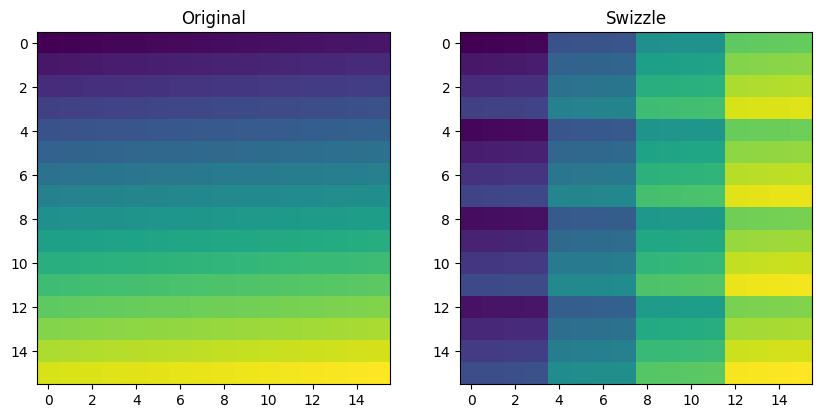

In [2]:
import matplotlib.pyplot as plt

@triton.jit
def orig(x_ptr, n0, n1, b0: tl.constexpr, b1: tl.constexpr):
    pid_0, pid_1 = tl.program_id(0), tl.program_id(1)
    off_0, off_1 = pid_0 * b0 + tl.arange(0, b0), pid_1 * b1 + tl.arange(0, b1)
    off_x = off_0[:, None] * n1 + off_1[None, :]
    tl.store(x_ptr + off_x, off_x)
    
@triton.jit
def swiz(x_ptr, n0, n1, b0: tl.constexpr, b1: tl.constexpr):
    pid_0, pid_1 = tl.program_id(0), tl.program_id(1)
    # original pids (used for color)
    orig_off_0, orig_off_1 = pid_0 * b0 + tl.arange(0, b0), pid_1 * b1 + tl.arange(0, b1)
    data = orig_off_0[:, None] * n1 + orig_off_1[None, :]
    # swizzle!
    # tile width: b0
    # we can then use pid_0 and pid_1 how we normally would
    num_0, num_1 = tl.num_programs(0), tl.num_programs(1)
    pid_0, pid_1 = tl.swizzle2d(pid_0, pid_1, num_0, num_1, b0)
    ###
    off_0, off_1 = pid_0 * b0 + tl.arange(0, b0), pid_1 * b1 + tl.arange(0, b1)
    msk_0, msk_1 = off_0 < n0, off_1 < n1
    
    off_x = off_0[:, None] * n1 + off_1[None, :]
    msk_x = msk_0[:, None] & msk_1[None, :]
    tl.store(x_ptr + off_x, data, msk_x)

n, m, b0, b1 = 16, 16, 4, 4

orig_out = torch.empty(n, m)
orig[(cdiv(n, b0), cdiv(m, b1))](orig_out, n, m, b0, b1)

swiz_out = torch.empty(n, m)
swiz[(cdiv(n, b0), cdiv(m, b1))](swiz_out, n, m, b0, b1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.imshow(orig_out)
ax2.imshow(swiz_out)
ax1.set_title("Original")
ax2.set_title("Swizzle")
plt.show()

## Tiled Matmul

In [3]:
def matmul(x, y, tile_width=4, batch_width=1):
    b, m,  k = x.shape
    b2, k2, n = y.shape
    assert b == b2 and k == k2
    assert x.dtype == y.dtype and x.device == y.device
    z = torch.empty(b, m, n, dtype=x.dtype, device=x.device)
    matmul_k[(cdiv(m, tile_width), cdiv(n, tile_width), cdiv(b, batch_width))](
        x, y, z,
        b, m, n, k,
        bw=batch_width, tw=tile_width,
    )
    return z

@triton.jit
def batchify(off_i, msk_i, off_b, msk_b, batch_stride):
    off_ib = off_b[:, None, None] * batch_stride + off_i[None, :, :]
    msk_ib = msk_b[:, None, None] & msk_i[None, :, :]
    return off_ib, msk_ib

@triton.jit
def matmul_k(
    x_ptr, y_ptr, z_ptr,
    b, m, n, k,
    bw: tl.constexpr, tw: tl.constexpr
):
    b, m, n, k = tl.multiple_of(b, bw), tl.multiple_of(m, tw), tl.multiple_of(n, tw), tl.multiple_of(k, tw)
    # m,n
    pid_m, pid_n, pid_b = tl.program_id(0), tl.program_id(1), tl.program_id(2)
    num_m, num_n = tl.num_programs(0), tl.num_programs(1)
    pid_m, pid_n = tl.swizzle2d(pid_m, pid_n, num_m, num_n, tw) # memory coalesce
    off_m, off_n = pid_m * tw + tl.arange(0, tw), pid_n * tw + tl.arange(0, tw)
    # b
    off_b = pid_b * bw + tl.arange(0, bw)
    msk_b = off_b < b

    total = tl.zeros((bw, tw, tw), dtype=tl.float32)
    for ki in tl.range(tl.cdiv(k, tw), num_stages=2, loop_unroll_factor=4):
        off_k = ki * tw + tl.arange(0, tw)

        # x: (m, k)
        # - stride by k
        # - tile down dim1
        off_x = off_m[:, None] * k + off_k[None, :]
        msk_x = (off_m < m)[:, None] & (off_k < k)[None, :]
        off_xb, msk_xb = batchify(off_x, msk_x, off_b, msk_b, batch_stride=m*k)
        x = tl.load(x_ptr + off_xb, msk_xb)
    
        # y: (k, n)
        # - stride by n
        # - tile down dim0
        off_y = off_k[:, None] * n + off_n[None, :]
        msk_y = (off_k < k)[:, None] & (off_n < n)[None, :]
        off_yb, msk_yb = batchify(off_y, msk_y, off_b, msk_b, batch_stride=k*n)
        y = tl.load(y_ptr + off_yb, msk_yb)

        total += tl.dot(x, y)

    # save tile at pid_b, pid_m, pid_n
    off_z = off_m[:, None] * n + off_n[None, :]
    msk_z = (off_m[:, None] < m) & (off_n[None, :] < n)
    off_zb, msk_zb = batchify(off_z, msk_z, off_b, msk_b, batch_stride=m*n)
    tl.store(z_ptr + off_zb, total, msk_zb)

x = torch.arange(24).reshape(2, 3, 4).float()
y = torch.arange(40).reshape(2, 4, 5).float()
z_gt = torch.einsum('bmk,bkn->bmn', x, y)
z = matmul(x, y, tile_width=2, batch_width=2)
print("=== pytorch ===")
print(z_gt)
print("\n=== matmul_k ===")
print(z)
torch.testing.assert_close(z, z_gt)
print("Passed!")

=== pytorch ===
tensor([[[  70.,   76.,   82.,   88.,   94.],
         [ 190.,  212.,  234.,  256.,  278.],
         [ 310.,  348.,  386.,  424.,  462.]],

        [[1510., 1564., 1618., 1672., 1726.],
         [1950., 2020., 2090., 2160., 2230.],
         [2390., 2476., 2562., 2648., 2734.]]])

=== matmul_k ===
tensor([[[  70.,   76.,   82.,   88.,   94.],
         [ 190.,  212.,  234.,  256.,  278.],
         [ 310.,  348.,  386.,  424.,  462.]],

        [[1510., 1564., 1618., 1672., 1726.],
         [1950., 2020., 2090., 2160., 2230.],
         [2390., 2476., 2562., 2648., 2734.]]])
Passed!


## Quantized Tiled Matmul

In [4]:
FPINT = 32 // 4
GROUP = 8

@triton.jit
def extract(x):
    over = tl.arange(0, 8) * 4
    mask = 2**4 - 1
    return (tl.expand_dims(x, -1) >> over) & mask


@triton.jit
def quant_matmul_k(
    scale_ptr, offset_ptr, weight_ptr, activation_ptr, z_ptr,
    b, m, n, k,
    bw: tl.constexpr, tw: tl.constexpr
):
    pid_0, pid_1 = tl.program_id(0), tl.program_id(1)
    off_0, off_1 = pid_0 * m + tl.arange(0, m), pid_1 * n + tl.arange(0, n)

    off_8 = tl.arange(0, 8)

    scale = tl.load(scale_ptr + off_0[:, None] * 8 + off_8[None, :], 
    
def quant_matmul(
    scale,
    offset,
    weight,
    activation,
    tile_width=4,
    batch_width=1,
):

    b, m, f = scale.shape
    b2, k, n = activation.shape
    assert f == FPINT and b == b2
    assert offset.shape == (b, m) and weight.shape == (b, m, f)
    z = torch.zeros(b, m, n)
    quant_matmul_k[(cdiv(m, tile_width), cdiv(n, tile_width), cdiv(b, batch_width))](
        scale, offset, weight, activation, z,
        b, m, n, k,
        bw=batch_width, tw=tile_width,
    )
    return z

def quant_matmul_gt(
    scale     : Float32[Tensor, "32 8" ],
    offset    : Int32[  Tensor, "32"   ],
    weight    : Int32[  Tensor, "32 8" ],
    activation: Float32[Tensor, "64 32"],
) -> Float32[Tensor, "32 32"]:
    offset = offset.view(32, 1)
    def extract(x):
        over = torch.arange(8) * 4
        mask = 2**4 - 1
        return (x[..., None] >> over) & mask
    scale = scale[..., None].expand(-1, 8, GROUP).contiguous().view(-1, 64)
    offset = extract(offset)[..., None].expand(-1, 1, 8, GROUP).contiguous().view(-1, 64)
    return ( scale * (extract(weight).view(-1, 64) - offset))  @ activation

SyntaxError: '(' was never closed (965855586.py, line 22)

In [ ]:
scale = torch.arange(32 * 8).reshape(

In [121]:
a = torch.tensor([0x12345678, 0x43534231], dtype=torch.int32)  # Just one value
over = torch.arange(8) * 4
mask = 2**4 - 1
result = (a[..., None] >> over) & mask
print(result)

tensor([[8, 7, 6, 5, 4, 3, 2, 1],
        [1, 3, 2, 4, 3, 5, 3, 4]])


In [139]:

def extract_gt(x):
    over = torch.arange(8) * 4
    mask = 2**4 - 1
    return (x[..., None] >> over) & mask

@triton.jit
def test_extract(x_ptr, z_ptr):
    x = tl.load(x_ptr + tl.arange(0, 2))
    ex_x = extract(x)
    tl.store(z_ptr + tl.arange(0, 8 * 2).reshape(2, 8), ex_x)
    

x = torch.tensor([0x12345678, 0x43534231], dtype=torch.int32)
extract_gt(x)

z = torch.zeros(2, 8, dtype=torch.int32)
test_extract[(1,)](x, z)
print(z)
print(extract_gt(x))


tensor([[8, 7, 6, 5, 4, 3, 2, 1],
        [1, 3, 2, 4, 3, 5, 3, 4]], dtype=torch.int32)
tensor([[8, 7, 6, 5, 4, 3, 2, 1],
        [1, 3, 2, 4, 3, 5, 3, 4]])


## Softmax

### (Simple) Vectorized Softmax

This loads an entire row at once, predicated that the row is no longer than `max_t_width`. This makes the code much clearer and more efficient.

In [5]:
@triton.jit
def softmax_k(x_ptr, z_ptr, n0, n1, b0: tl.constexpr, b1: tl.constexpr):
    tl.static_assert(n1 <= b1, "sequence length exceeds max block size")
    log2_e = 1.44269504
    pid_0 = tl.program_id(0)
    off_0 = pid_0 * b0 + tl.arange(0, b0)
    msk_0 = off_0 < n0

    off_1 = tl.arange(0, b1)
    msk_1 = off_1 < n1

    off = off_0[:, None] * n1 + off_1[None, :]
    msk = msk_0[:, None] & msk_1[None, :]

    x = tl.load(x_ptr + off, msk, -float('inf'))
    exp_x = tl.exp2(log2_e * (x - tl.max(x, axis=1, keep_dims=True))) 
    z = exp_x / tl.sum(exp_x, axis=1, keep_dims=True)
    tl.store(z_ptr + off, z, msk)
    
def softmax(x, batch_width=2, max_t_width=2048):
    b, t = x.shape
    z = torch.empty(b, t, device=x.device, dtype=x.dtype)
    softmax_k[(cdiv(b, batch_width),)](
        x, z,
        b, t,
        b0=batch_width, b1=max_t_width
    )
    return z


def softmax_gt(x):
    b, t = x.shape
    x_max = x.max(1, keepdim=True)[0]
    x = x - x_max
    x_exp = x.exp()
    return x_exp / x_exp.sum(1, keepdim=True)

x = torch.randn(4, 32).float()
z_gt = softmax_gt(x)
z = softmax(x)
print("=== pytorch ===")
print(z_gt[:2, :8])
print("\n=== softmax_k ===")
print(z[:2, :8])
torch.testing.assert_close(z, z_gt)
print("Passed!")

=== pytorch ===
tensor([[0.0202, 0.1261, 0.0310, 0.0108, 0.0319, 0.0405, 0.0212, 0.0103],
        [0.0520, 0.1045, 0.0138, 0.0075, 0.0269, 0.0037, 0.0063, 0.0071]])

=== softmax_k ===
tensor([[0.0202, 0.1261, 0.0310, 0.0108, 0.0319, 0.0405, 0.0212, 0.0103],
        [0.0520, 0.1045, 0.0138, 0.0075, 0.0269, 0.0037, 0.0063, 0.0071]])
Passed!


### Naive Softmax

Softmax closer to a cuda version. This allows the row width to be arbitaritly large.

In [6]:
@triton.jit
def softmax_k(x_ptr, z_ptr, n0, n1, b0: tl.constexpr, b1: tl.constexpr):
    log2_e = 1.44269504
    pid_0 = tl.program_id(0)
    off_0 = pid_0 * b0 + tl.arange(0, b0)
    msk_0 = off_0 < n0

    _max = tl.full((b0, 1), -float('inf'), dtype=tl.float32)
    for i_1 in tl.range(tl.cdiv(n1, b1)):
        off_1 = i_1 * b1 + tl.arange(0, b1)
        msk_1 = off_1 < n1
        off_x = off_0[:, None] * n1 + off_1[None, :]
        msk_x = msk_0[:, None] & msk_1[None, :]
        x = tl.load(x_ptr + off_x, msk_x, -float('inf'))
        x_max = tl.max(x, axis=1, keep_dims=1)
        _max = tl.where(_max > x_max, _max, x_max)

    tot = tl.zeros((b0, 1),  dtype=tl.float32)
    for i_1 in tl.range(tl.cdiv(n1, b1)):
        off_1 = i_1 * b1 + tl.arange(0, b1)
        msk_1 = off_1 < n1
        off_x = off_0[:, None] * n1 + off_1[None, :]
        msk_x = msk_0[:, None] & msk_1[None, :]
        x = tl.load(x_ptr + off_x, msk_x, -float('inf')) # (b0, b1)
        x = x - _max
        exp_x = tl.exp2(log2_e * x)
        tot += tl.sum(exp_x, axis=1, keep_dims=True)
        tl.store(z_ptr + off_x, exp_x, msk_x)
        
    for i_1 in tl.range(tl.cdiv(n1, b1)):
        off_1 = i_1 * b1 + tl.arange(0, b1)
        msk_1 = off_1 < n1
        off_x = off_0[:, None] * n1 + off_1[None, :]
        msk_x = msk_0[:, None] & msk_1[None, :]
        exp_x = tl.load(z_ptr + off_x, msk_x) # (b0, b1)
        z = exp_x / tot
        tl.store(z_ptr + off_x, z, msk_x)

def softmax(x, batch_width=2, t_width=16):
    b, t = x.shape
    z = torch.empty(b, t, device=x.device, dtype=x.dtype)
    softmax_k[(cdiv(b, batch_width),)](
        x, z,
        b, t,
        b0=batch_width, b1=t_width
    )
    return z
x = torch.randn(4, 20).float()
z_gt = softmax_gt(x)
z = softmax(x)
print("=== pytorch ===")
print(z_gt[:2, :8])
print("\n=== softmax_k ===")
print(z[:2, :8])
torch.testing.assert_close(z, z_gt)
print("Passed!")

=== pytorch ===
tensor([[0.0129, 0.0252, 0.0320, 0.0426, 0.0252, 0.0781, 0.1193, 0.0392],
        [0.0034, 0.1132, 0.1172, 0.3084, 0.0563, 0.0414, 0.0152, 0.0136]])

=== softmax_k ===
tensor([[0.0129, 0.0252, 0.0320, 0.0426, 0.0252, 0.0781, 0.1193, 0.0392],
        [0.0034, 0.1132, 0.1172, 0.3084, 0.0563, 0.0414, 0.0152, 0.0136]])
Passed!


### Online Softmax

Similar to flash attention softmax, this uses the property:

$$
$$

to only perform two loops through the data.

In [7]:
@triton.jit
def softmax_k(x_ptr, z_ptr, n0, n1, b0: tl.constexpr, b1: tl.constexpr):
    log2_e = 1.44269504
    pid_0 = tl.program_id(0)
    off_0 = pid_0 * b0 + tl.arange(0, b0)
    msk_0 = off_0 < n0

    _max = tl.full((b0, 1), -float('inf'), dtype=tl.float32)
    _sum = tl.zeros((b0, 1), dtype=tl.float32)
    for i_1 in tl.range(tl.cdiv(n1, b1)):
        off_1 = i_1 * b1 + tl.arange(0, b1)
        msk_1 = off_1 < n1
        off_x = off_0[:, None] * n1 + off_1[None, :]
        msk_x = msk_0[:, None] & msk_1[None, :]

        x = tl.load(x_ptr + off_x, msk_x, -float('inf'))
        x_max = tl.max(x, axis=1, keep_dims=1)

        old_x_sum_scale = tl.exp2(log2_e * (_max - x_max))
        _sum = tl.where(x_max > _max, _sum * old_x_sum_scale, _sum)
        _max = tl.where(x_max > _max, x_max, _max)

        x_sum = tl.sum(tl.exp2(log2_e * (x - _max)), axis=1, keep_dims=True)
        _sum = _sum + x_sum

    for i_1 in tl.range(tl.cdiv(n1, b1)):
        off_1 = i_1 * b1 + tl.arange(0, b1)
        msk_1 = off_1 < n1
        off_x = off_0[:, None] * n1 + off_1[None, :]
        msk_x = msk_0[:, None] & msk_1[None, :]
        x = tl.load(x_ptr + off_x, msk_x, 0) # (b0, b1)
        z = tl.exp2(log2_e * (x - _max)) / _sum
        tl.store(z_ptr + off_x, z, msk_x)

x = torch.randn(4, 20).float()
z_gt = softmax_gt(x)
z = softmax(x)
print("=== pytorch ===")
print(z_gt[:2, :8])
print("\n=== softmax_k ===")
print(z[:2, :8])
torch.testing.assert_close(z, z_gt)
print("Passed!")

=== pytorch ===
tensor([[0.0653, 0.0214, 0.0079, 0.0573, 0.1437, 0.1421, 0.0149, 0.0141],
        [0.0207, 0.0473, 0.0204, 0.0436, 0.0662, 0.2507, 0.0162, 0.1934]])

=== softmax_k ===
tensor([[0.0653, 0.0214, 0.0079, 0.0573, 0.1437, 0.1421, 0.0149, 0.0141],
        [0.0207, 0.0473, 0.0204, 0.0436, 0.0662, 0.2507, 0.0162, 0.1934]])
Passed!


In [1]:
import torch
import triton
from torch import Tensor
import triton.language as tl
import jaxtyping
from jaxtyping import Float32, Int32

# @title Setup

import triton_viz
import inspect
from triton_viz.interpreter import record_builder

def test(puzzle, puzzle_spec, nelem={}, B={"B0": 32}, viz=False):
    B = dict(B)
    if "N1" in nelem and "B1" not in B:
        B["B1"] = 32
    if "N2" in nelem and "B2" not in B:
        B["B2"] = 32

    triton_viz.interpreter.record_builder.reset()
    torch.manual_seed(0)
    signature = inspect.signature(puzzle_spec)
    args = {}
    for n, p in signature.parameters.items():
        print(p)
        args[n + "_ptr"] = ([d.size for d in p.annotation.dims], p)
    args["z_ptr"] = ([d.size for d in signature.return_annotation.dims], None)

    tt_args = []
    for k, (v, t) in args.items():
        tt_args.append(torch.rand(*v) - 0.5)
        if t is not None and t.annotation.dtypes[0] == "int32":
            tt_args[-1] = torch.randint(-100000, 100000, v)
    grid = lambda meta: (triton.cdiv(nelem["N0"], meta["B0"]),
                         triton.cdiv(nelem.get("N1", 1), meta.get("B1", 1)),
                         triton.cdiv(nelem.get("N2", 1), meta.get("B2", 1)))

    for k, v in args.items():
       print(k, v)
    triton_viz.trace(puzzle)[grid](*tt_args, **B, **nelem)
    z = tt_args[-1]
    tt_args = tt_args[:-1]
    z_ = puzzle_spec(*tt_args)
    match = torch.allclose(z, z_, rtol=1e-3, atol=1e-3)
    print("Results match:",  match)
    failures = False
    if viz:
        failures = triton_viz.launch()
    if not match or failures:
        print("Invalid Access:", failures)
        print("Yours:", z)
        print("Spec:", z_)
        print(torch.isclose(z, z_))
        return
    # PUPPIES!
    from IPython.display import HTML
    import random
    print("Correct!")